In [221]:
# --- Load cohort file; build tidy "long"; exact-match-aware interpolate(); validator ---

import pandas as pd
import numpy as np

# ===== CONFIG =====
path = "/Users/erikborn/Documents/Python/jupyter/Salary_ML/statecohortData.csv"  # adjust
label_col = "State"
base_col  = "Full-Time Teacher Base Salaries: Starting ($)"  # <-- will be EXCLUDED
band_cols_expected = [
    "0-5 yrs","6-10 yrs","11-15 yrs","16-20 yrs","21-25 yrs",
    "26-30 yrs","31-35 yrs","36+ yrs","41+ Years"
]
# ==================

goal_percentile = 70
cola_rate = 0.02   # 2% bump for anyone whose base >= model target
target_inflation=0.03

# Robust numeric parser
def to_num(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.floating)):
        return float(x)
    s = str(x)
    s = (s.replace("\u00a0"," ").replace("\u2009"," ")
           .replace("—","-").replace("–","-").strip())
    s = s.replace("$","").replace(",","").replace(" ","")
    if s in {"", "--", "-", "NA", "N/A", "na"}:
        return np.nan
    try:
        return float(s)
    except ValueError:
        return np.nan

# 1) Load
raw = pd.read_csv(path)
raw.columns = [c.strip() for c in raw.columns]

# 2) Identify band columns strictly from your list (and present in file)
band_cols = [c for c in band_cols_expected if c in raw.columns]

# 3) Clean only the band columns (EXCLUDE base_col from interpolation path)
clean = raw.copy()
for c in band_cols:
    clean[c] = clean[c].map(to_num)

# 4) Normalize percentile labels -> short + numeric
lbl = clean[label_col].astype(str).str.lower().str.strip()
lbl = lbl.replace({
    "90th percentile": "p90",
    "75th percentile": "p75",
    "50th percentile (median)": "p50",
    "50th percentile": "p50",
    "25th percentile": "p25",
    "10th percentile": "p10",
})
clean["percentile_label"] = lbl
pmap = {"p10":10, "p25":25, "p50":50, "p75":75, "p90":90}
clean["percentile"] = clean["percentile_label"].map(pmap)

# 5) Tidy long (id_vars excludes base_col; value_vars are the band columns only)
long = (
    clean.melt(
        id_vars=["percentile_label","percentile"],
        value_vars=band_cols,
        var_name="experience_band",
        value_name="salary"
    )
    .dropna(subset=["percentile","salary"])
    .sort_values(["experience_band","percentile"])
    .reset_index(drop=True)
)

# 6) Interpolator that returns exact anchor if present; else linear interpolate
def interpolate_salary(df_long: pd.DataFrame, experience_band: str, target_percentile: float):
    sub = df_long.loc[
        df_long["experience_band"] == experience_band, ["percentile","salary"]
    ].dropna()

    if sub.empty:
        return np.nan

    # Collapse duplicates; keep the first non-null salary for each percentile
    sub = (sub.sort_values(["percentile","salary"])
              .drop_duplicates(subset=["percentile"], keep="first"))

    xs = sub["percentile"].to_numpy(dtype=float)
    ys = sub["salary"].to_numpy(dtype=float)

    # Exact match (handles 10/25/50/75/90 cleanly)
    t = float(target_percentile)
    idx = np.where(np.isclose(xs, t, atol=1e-9))[0]
    if idx.size:
        return float(ys[idx[0]])

    # Interpolate within bounds; clip to avoid extrapolation
    t_clip = float(np.clip(t, xs.min(), xs.max()))
    return float(np.interp(t_clip, xs, ys))

# 7) Quick validation: anchors should round-trip exactly
def validate_against_anchors(df_long: pd.DataFrame, anchors=(10,25,50,75,90), atol=0.5):
    issues = []
    for band in sorted(df_long["experience_band"].unique(),
                       key=lambda b: int(str(b).split("-")[0].split("+")[0])):
        sub = df_long[df_long["experience_band"] == band]
        for p in anchors:
            src_series = sub.loc[sub["percentile"] == p, "salary"]
            if src_series.empty:
                continue
            src = float(src_series.iloc[0])
            got = interpolate_salary(df_long, band, p)
            if not np.isfinite(got) or abs(src - got) > atol:
                issues.append((band, p, src, got))
    if issues:
        print("Mismatches (band, P, src, got):")
        for b,p,s,g in issues:
            print(f"{b:>10s}  P{p:>2d}:  src={s:,.2f}  got={g:,.2f}")
    else:
        print("All anchor percentiles match source values within tolerance.")

# Smoke test (pick a band present in file)
if len(long):
    band0 = long["experience_band"].iloc[0]
    print("Example:", band0, "P75 ->", f"{interpolate_salary(long, band0, 75):,.0f}")
    validate_against_anchors(long)

Example: 0-5 yrs P75 -> 56,995
All anchor percentiles match source values within tolerance.


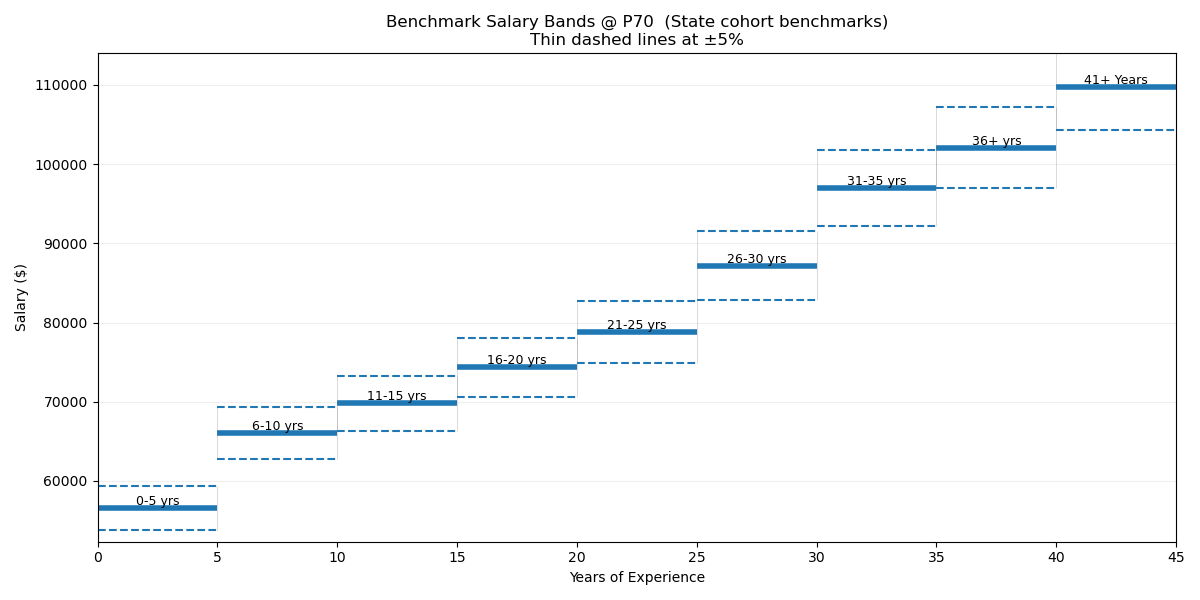

In [222]:
# --- Plot salary bands as contiguous 5-year segments with +/- pct guides ---

import re
import numpy as np
import matplotlib.pyplot as plt

target_percentile = goal_percentile
plus_minus_pct    = 0.05
title_suffix      = "State cohort benchmarks"

def band_range_contiguous(label: str):
    """
    Labels like '0-5 yrs', '6-10 yrs', '36+ yrs', '41+ Years'.
    Returns (start, end) for a contiguous 5-yr span:
      '0-5'  -> [0,5)
      '6-10' -> [5,10)
      '11-15'-> [10,15)
      '41+'  -> [40,45)
    """
    s = str(label).strip()
    m = re.match(r"^\s*(\d+)\s*(?:-\s*\d+|\+)\s*(?:yrs|years)?\s*$", s, flags=re.IGNORECASE)
    if not m:
        raise ValueError(f"Unrecognized band label: {label!r}")
    a = int(m.group(1))
    start = a if a == 0 else a - 1
    end = start + 5
    return start, end

# Build segments at chosen percentile
bands = sorted(
    [b for b in long["experience_band"].dropna().unique()],
    key=lambda b: band_range_contiguous(b)[0]
)

segments = []
for b in bands:
    y = interpolate_salary(long, b, target_percentile)
    if np.isnan(y):
        continue
    x0, x1 = band_range_contiguous(b)
    segments.append({"band": b, "x0": x0, "x1": x1, "y": y})

if not segments:
    raise RuntimeError("No segments to plot. Check data/percentile.")

max_x = max(s["x1"] for s in segments)
min_y = min(s["y"] for s in segments)
max_y = max(s["y"] for s in segments)
y_pad = 0.08 * ((max_y - min_y) if max_y > min_y else max_y)

plt.figure(figsize=(12, 6))

for s in segments:
    plt.hlines(s["y"], s["x0"], s["x1"], linewidth=4, color="C0")
    y_lo = s["y"] * (1 - plus_minus_pct)
    y_hi = s["y"] * (1 + plus_minus_pct)
    plt.hlines(y_lo, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed", color="C0")
    plt.hlines(y_hi, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed", color="C0")
    plt.vlines([s["x0"], s["x1"]], ymin=y_lo, ymax=y_hi, colors="gray", linewidth=0.5, alpha=0.4)
    mid = (s["x0"] + s["x1"]) / 2
    plt.text(mid, s["y"], s["band"], ha="center", va="bottom", fontsize=9)

plt.xlim(0, max_x)
plt.ylim(min_y - y_pad, max_y + y_pad)
plt.xlabel("Years of Experience")
plt.ylabel("Salary ($)")
plt.title(
    f"Benchmark Salary Bands @ P{target_percentile:g}  ({title_suffix})\n"
    f"Thin dashed lines at ±{plus_minus_pct*100:.0f}%"
)
plt.grid(axis="y", alpha=0.2)
plt.xticks(np.arange(0, max_x + 1, 5))
plt.tight_layout()
plt.show()
plt.close()

       Years of Exp  25-26 Salary
count         78.00         78.00
mean          14.37      70832.19
std            9.95      10685.39
min            0.00      52125.00
25%            7.00      65223.00
50%           13.00      69848.00
75%           18.75      76892.50
max           48.00     101894.00


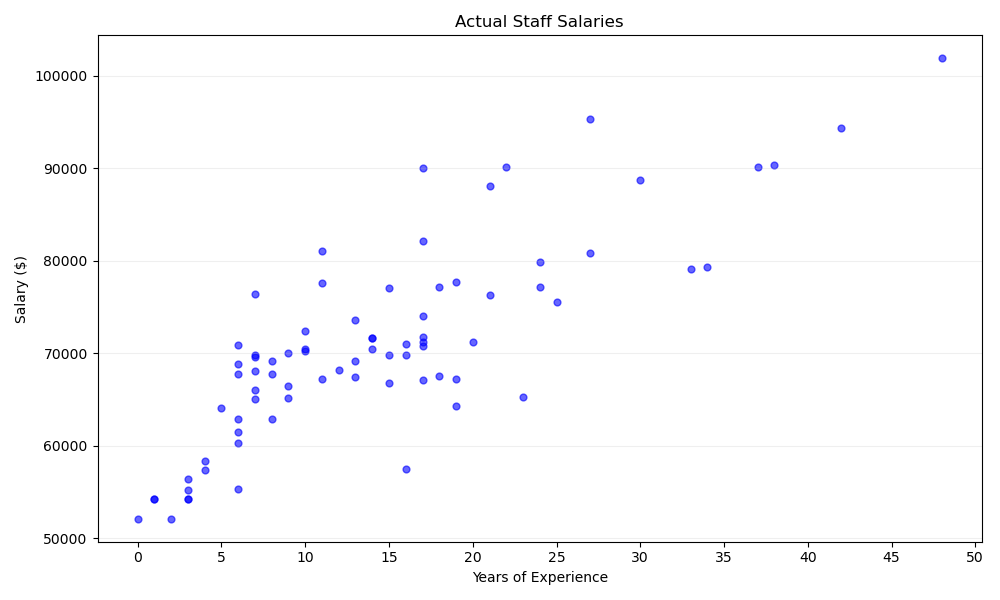

In [223]:
# --- Load & clean staff salary CSV (new schema), then plot salaries vs. years of experience ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====== CONFIG ======
path_staff = "/Users/erikborn/Documents/Python/jupyter/Salary_ML/modelData4.csv"  # set your path
salary_col = "25-26 Salary"
years_col  = "Years of Exp"        # expects numeric (int/float)
# ====================

# Helpers
def to_num_currency(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).strip().replace("$", "").replace(",", "")
    try:
        return float(s)
    except ValueError:
        return np.nan

def coerce_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

# Load
staff_raw = pd.read_csv(path_staff)

# Standardize headers
staff_raw.columns = [c.strip() for c in staff_raw.columns]

expected_cols = {
    "Employee","ID","25-26 Salary","Hire Date","Eth","Gender","Years of Exp","Seniority",
    "Education Level","Skill Rating","Knowledge Rating","Prep Rating","Level","Category"
}
missing = [c for c in expected_cols if c not in staff_raw.columns]
if missing:
    print("Warning: Missing expected columns:", missing)

# Clean
staff = staff_raw.copy()

# Currency -> float
if salary_col in staff.columns:
    staff[salary_col] = staff[salary_col].map(to_num_currency)

# Years of experience -> float
if years_col in staff.columns:
    staff[years_col] = staff[years_col].map(coerce_float)

# Optional: parse Hire Date (kept as datetime for later use; not required for this plot)
if "Hire Date" in staff.columns:
    staff["Hire Date"] = pd.to_datetime(staff["Hire Date"], errors="coerce")

# Normalize a few text fields (useful later)
for tcol in ["Education Level", "Level", "Gender", "Eth", "Category"]:
    if tcol in staff.columns:
        staff[tcol] = staff[tcol].astype(str).str.strip()

# Drop rows without the two essentials
staff = staff.dropna(subset=[salary_col, years_col])

# Optional: clip obvious outliers (uncomment if desired)
# staff = staff[(staff[years_col] >= 0) & (staff[years_col] <= 45) & (staff[salary_col] > 0)]

# Quick summary
print(staff[[years_col, salary_col]].describe().round(2))

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(staff[years_col], staff[salary_col], alpha=0.6, s=24, color="blue")
plt.xlabel("Years of Experience")
plt.ylabel("Salary ($)")
plt.title("Actual Staff Salaries")
plt.grid(axis="y", alpha=0.2)

# Nice x ticks
max_years_obs = np.nanmax(staff[years_col].to_numpy()) if len(staff) else 40
plt.xticks(np.arange(0, max(40, int(np.ceil(max_years_obs/5)*5)) + 1, 5))

plt.tight_layout()
plt.show()
plt.close()

Note: you may need to restart the kernel to use updated packages.


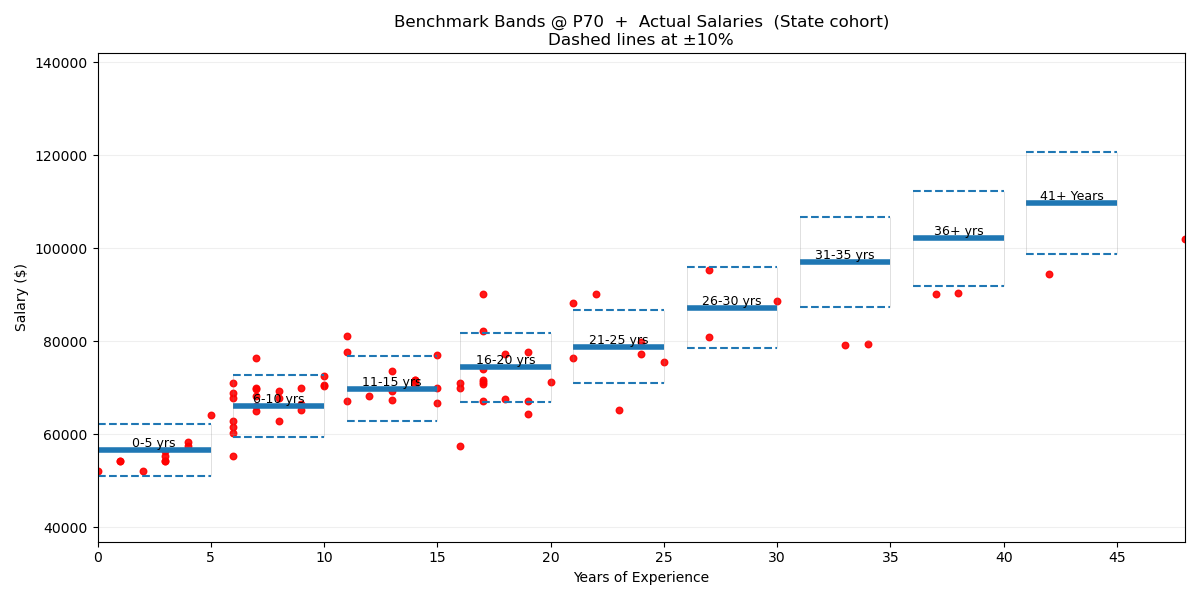

In [224]:
# --- Interactive benchmark bands (closed intervals) + staff tooltips ---
%pip install -q ipympl mplcursors
%matplotlib widget

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
from functools import lru_cache
import mplcursors

# Assumes `long`, `interpolate_salary`, and `staff` are already defined.

def band_range_closed(label: str):
    """
    Labels like '0-5 yrs', '6-10 yrs', '36+ yrs', '41+ Years' (case-insensitive).
    Returns CLOSED spans [start, end] using the literal numbers in the label.
      '0-5'  -> [0, 5]
      '6-10' -> [6, 10]
      ...
      '41+'  -> [41, 45]   (kept at 5-year width to render consistently)
    """
    s = str(label).strip()
    # capture "A-B" or "A+"
    m_range = re.match(r"^\s*(\d+)\s*-\s*(\d+)\s*(?:yrs|years)?\s*$", s, flags=re.IGNORECASE)
    m_plus  = re.match(r"^\s*(\d+)\s*\+\s*(?:yrs|years)?\s*$", s, flags=re.IGNORECASE)
    if m_range:
        a, b = int(m_range.group(1)), int(m_range.group(2))
        return a, b
    if m_plus:
        a = int(m_plus.group(1))
        return a, a + 4  # closed [a, a+4] => 5-year width
    raise ValueError(f"Unrecognized band label: {label!r}")

bands = sorted(
    long["experience_band"].dropna().unique(),
    key=lambda b: band_range_closed(b)[0]
)

percentiles = list(range(10, 91, 5))

@lru_cache(maxsize=None)
def precomputed_for_percentile(p: int):
    rows = []
    for b in bands:
        y = interpolate_salary(long, b, p)
        if not np.isnan(y):
            x0, x1 = band_range_closed(b)
            rows.append({"band": b, "x0": x0, "x1": x1, "y": float(y)})
    return rows

# Fixed axes so the view doesn't jump across slider values
all_ys, all_xmax = [], []
for p in percentiles:
    segs = precomputed_for_percentile(p)
    all_ys.extend([s["y"] for s in segs])
    all_xmax.extend([s["x1"] for s in segs])

max_years_staff = 0
if len(staff):
    if "25-26 Salary" in staff.columns:
        all_ys.extend(staff["25-26 Salary"].dropna().to_numpy())
    if "Years of Exp" in staff.columns:
        max_years_staff = float(np.nanmax(staff["Years of Exp"].to_numpy()))

_global_min_y = float(np.nanmin(all_ys))
_global_max_y = float(np.nanmax(all_ys))
_max_x = max(all_xmax + [max_years_staff, 40])

_headroom = 0.25
_ymin_fixed = _global_min_y * (1 - _headroom)
_ymax_fixed = _global_max_y * (1 + _headroom)

# Staff view for plotting/tooltip lookup
cols_for_plot = ["Employee", "ID", "Years of Exp", "25-26 Salary", "Level",
                 "Education Level", "Gender", "Eth", "Category"]
staff_plot = (
    staff[[c for c in cols_for_plot if c in staff.columns]]
    .dropna(subset=["Years of Exp", "25-26 Salary"])
    .copy()
)

def fmt_currency(v: float) -> str:
    return f"${v:,.0f}"

def plot_bands_with_staff_hover(p=target_percentile, plus_minus_pct=0.10, title_suffix="State cohort"):
    segs = precomputed_for_percentile(int(p))
    if not segs:
        raise RuntimeError("No segments to plot.")

    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # benchmark bands (closed intervals)
    for s in segs:
        ax.hlines(s["y"], s["x0"], s["x1"], linewidth=4, color="C0")
        y_lo = s["y"] * (1 - plus_minus_pct)
        y_hi = s["y"] * (1 + plus_minus_pct)
        ax.hlines(y_lo, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed", color="C0")
        ax.hlines(y_hi, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed", color="C0")
        ax.vlines([s["x0"], s["x1"]], ymin=y_lo, ymax=y_hi, colors="gray", linewidth=0.5, alpha=0.35)
        mid_x = (s["x0"] + s["x1"]) / 2
        ax.text(mid_x, s["y"], s["band"], ha="center", va="bottom", fontsize=9)

    # staff scatter (red points)
    sc = ax.scatter(staff_plot["Years of Exp"], staff_plot["25-26 Salary"], s=22, alpha=0.9, color="red")

    # fixed axes
    ax.set_xlim(0, _max_x)
    ax.set_ylim(_ymin_fixed, _ymax_fixed)
    ax.set_xlabel("Years of Experience")
    ax.set_ylabel("Salary ($)")
    ax.set_title(
        f"Benchmark Bands @ P{int(p)}  +  Actual Salaries  ({title_suffix})\n"
        f"Dashed lines at ±{plus_minus_pct*100:.0f}%"
    )
    ax.grid(axis="y", alpha=0.2)
    ax.set_xticks(np.arange(0, _max_x + 1, 5))
    plt.tight_layout()

    # Hover tooltips
    cursor = mplcursors.cursor(sc, hover=True)

    @cursor.connect("add")
    def on_add(sel):
        i = sel.index
        row = staff_plot.iloc[i]
        text = (
            f"{row.get('Employee', '')}\n"
            f"ID: {row.get('ID', '')}\n"
            f"Years: {row['Years of Exp']:.1f}\n"
            f"Salary: {fmt_currency(row['25-26 Salary'])}\n"
            f"Level: {row.get('Level', '')}\n"
            f"Edu: {row.get('Education Level', '')}\n"
            f"Gender: {row.get('Gender', '')}\n"
            f"Eth: {row.get('Eth', '')}\n"
            f"Category: {row.get('Category', '')}"
        )
        sel.annotation.set_text(text)
        sel.annotation.get_bbox_patch().set_alpha(0.9)

    plt.show()

plot_bands_with_staff_hover(p=target_percentile, plus_minus_pct=0.10, title_suffix="State cohort")

In [225]:
# --- Cost model with "keep-above + uplift" rule --------------------------------
# Rule:
#   per-person target = max(band_target, current_salary * (1 + keep_above_uplift))
# ------------------------------------------------------------------------------
# --- Closed-interval band logic: [0,5], [6,10], [11,15], … ---

import re
import numpy as np
import pandas as pd

def band_range_closed(label: str):
    """
    Accepts '0-5 yrs', '6-10 yrs', '11-15 yrs', '36+ yrs', '41+ Years' (case-insensitive).
    Returns (start, end) with CLOSED intervals: [start, end].
      '0-5'  -> (0, 5)
      '6-10' -> (6, 10)
      '41+'  -> (41, +inf)
    """
    s = str(label).strip()
    m_range = re.match(r"^\s*(\d+)\s*-\s*(\d+)\s*(?:yrs|years)?\s*$", s, flags=re.IGNORECASE)
    m_plus  = re.match(r"^\s*(\d+)\s*\+\s*(?:yrs|years)?\s*$", s, flags=re.IGNORECASE)
    if m_range:
        a, b = int(m_range.group(1)), int(m_range.group(2))
        return float(a), float(b)
    if m_plus:
        a = int(m_plus.group(1))
        return float(a), np.inf
    raise ValueError(f"Unrecognized band label: {label!r}")

def build_band_bins_closed(long_df: pd.DataFrame):
    bands = sorted(
        long_df["experience_band"].dropna().unique(),
        key=lambda b: band_range_closed(b)[0]
    )
    bins = []
    for b in bands:
        start, end = band_range_closed(b)
        bins.append((start, end, b))
    return bins, bands

def assign_band_from_years_closed(years: float, bins):
    """
    Closed-interval assignment:
      y in [start, end]  -> band
      For '+', end is +inf so any y >= start matches.
    """
    if pd.isna(years):
        return np.nan
    y = float(years)
    for start, end, label in bins:
        if np.isfinite(end):
            if (y >= start) and (y <= end):
                return label
        else:  # +inf band
            if y >= start:
                return label
    return np.nan

def cost_to_percentile(
    long_df: pd.DataFrame,
    staff_df: pd.DataFrame,
    target_percentile: float = target_percentile,
    salary_col: str = "25-26 Salary",
    years_col: str = "Years of Exp",
    target_inflation: float = target_inflation,
    keep_above_uplift: float = cola_rate,      # <-- NEW: uplift for people already above the band
    staff_filter: pd.Series | None = None
):
    """
    Estimate cost to bring all staff to a chosen percentile per band, with:
      - Forward inflation on the cohort target (target_inflation)
      - 'Keep-above + uplift' rule: target_i = max(band_target, current_i * (1 + keep_above_uplift))

    Returns per-band rows plus a TOTAL row with:
      band, headcount, num_above_band, current_total, band_target_salary,
      target_total, delta, delta_per_head
    """
    bins, band_order = build_band_bins_closed(long_df)

    staff_view = staff_df[[years_col, salary_col]].copy()
    if staff_filter is not None:
        staff_view = staff_view[staff_filter.values]

    # Closed-interval assignment here:
    staff_view["band"] = staff_view[years_col].apply(lambda y: assign_band_from_years_closed(y, bins))
    staff_view = staff_view.dropna(subset=["band", salary_col]).copy()

    # Build band targets (apply inflation)
    target_map = {}
    for _, _, b in bins:
        y = interpolate_salary(long_df, b, target_percentile)
        if not np.isnan(y):
            target_map[b] = float(y) * (1 + float(target_inflation))

    # Attach band target to each person (NaN if band not in map)
    staff_view["band_target_salary"] = staff_view["band"].map(target_map)

    # Compute per-person target under the rule
    cur = staff_view[salary_col].to_numpy(dtype=float)
    band_t = staff_view["band_target_salary"].to_numpy(dtype=float)
    # If a band's target is missing (NaN), treat band_t as -inf so current*(1+uplift) is chosen
    band_t = np.where(np.isfinite(band_t), band_t, -np.inf)

    keep_above = cur * (1.0 + float(keep_above_uplift))
    person_target = np.maximum(band_t, keep_above)

    staff_view["person_target_salary"] = person_target
    staff_view["above_band"] = cur > band_t  # who is already above the (inflated) band target

    # Aggregate per band
    per_band = (
        staff_view
        .groupby("band", as_index=False)
        .agg(
            headcount=(salary_col, "size"),
            num_above_band=("above_band", "sum"),
            current_total=(salary_col, "sum"),
            target_total=("person_target_salary", "sum"),
            band_target_salary=("band_target_salary", "first")  # same within band
        )
    )

    per_band["delta"] = per_band["target_total"] - per_band["current_total"]
    per_band["delta_per_head"] = per_band["delta"] / per_band["headcount"].replace({0: np.nan})

    # Order by band start
    per_band["__start__"] = per_band["band"].apply(lambda b: band_range_contiguous(b)[0] if pd.notna(b) else 1e9)
    per_band = per_band.sort_values("__start__").drop(columns="__start__")

    # Totals row
    totals = {
        "band": "TOTAL",
        "headcount": int(per_band["headcount"].sum()) if len(per_band) else 0,
        "num_above_band": int(per_band["num_above_band"].sum()) if len(per_band) else 0,
        "current_total": float(per_band["current_total"].sum()) if len(per_band) else 0.0,
        "band_target_salary": np.nan,
        "target_total": float(per_band["target_total"].sum()) if len(per_band) else 0.0,
        "delta": float(per_band["delta"].sum()) if len(per_band) else 0.0,
        "delta_per_head": float(per_band["delta"].sum()) / max(int(per_band["headcount"].sum()), 1),
    }

    return pd.concat([per_band, pd.DataFrame([totals])], ignore_index=True)

# Example usage
result = cost_to_percentile(
    long_df=long,
    staff_df=staff,
    target_percentile=target_percentile,       # try 60, 75, etc.
    target_inflation=target_inflation,      # e.g., +0.04 for +4% forward look
    keep_above_uplift=cola_rate,     # default 2% uplift for those already above band target
    salary_col="25-26 Salary",
    years_col="Years of Exp",
    # staff_filter=staff["Category"].eq("Faculty") if "Category" in staff.columns else None
)

# Formatting for display
def fmt_money(x):
    return "" if pd.isna(x) else f"${x:,.0f}"

display(
    result.style.format({
        "current_total": fmt_money,
        "band_target_salary": fmt_money,
        "target_total": fmt_money,
        "delta": fmt_money,
        "delta_per_head": fmt_money
    })
)

,band,headcount,num_above_band,current_total,target_total,band_target_salary,delta,delta_per_head
0,0-5 yrs,11,2,"$612,830","$649,615","$58,273","$36,785","$3,344"
1,6-10 yrs,22,11,"$1,477,226","$1,542,131","$68,043","$64,905","$2,950"
2,11-15 yrs,13,4,"$931,689","$964,725","$71,867","$33,036","$2,541"
3,16-20 yrs,16,4,"$1,150,533","$1,252,308","$76,557","$101,775","$6,361"
4,21-25 yrs,7,2,"$552,362","$588,005","$81,178","$35,643","$5,092"
5,26-30 yrs,3,1,"$264,973","$277,572","$89,791","$12,599","$4,200"
6,31-35 yrs,2,0,"$158,551","$199,785","$99,892","$41,234","$20,617"
7,36+ yrs,4,0,"$376,747","$420,565","$105,141","$43,818","$10,955"
8,TOTAL,78,24,"$5,524,911","$5,894,706",,"$369,795","$4,741"


In [226]:
# --- Nonlinear salary model (degree = % multiplier on total) ---

import numpy as np
import pandas as pd
import re

# ==== CONFIG (tune these) ====
base_salary             = 55000.0

# Experience contribution: cumulative effect with diminishing marginal return
exp_base_per_year       = 1250.0
exp_half_life_years     = 20.0

# Seniority-at-school contribution
sen_base_per_year       = 600.0
sen_half_life_years     = exp_half_life_years

# Degrees: PERCENT multipliers (overall)
deg_ma_pct              = 0.04   # +4% for MA (example)
deg_phd_pct             = 0.08   # +8% for PhD/EdD (example)
stack_degrees           = False  # if True, MA & PhD both apply multiplicatively

# Optional linear components (set to 0 to ignore)
w_skill                 = 0.0
w_prep                  = 0.0
w_knowledge             = 0.0
level_adders            = {"LS": 0.0, "MS": 0.0, "HS": 0.0}

# Scale the whole curve (useful when "aiming" to an overall percentile)
aim_multiplier          = 1.0
# =============================

def _coerce_num_col(s: pd.Series) -> pd.Series:
    if s is None:
        return pd.Series(0.0, index=staff.index)
    return pd.to_numeric(s, errors="coerce").fillna(0.0)

def exp_cumulative(years, base_per_year, half_life):
    years = np.maximum(0.0, np.asarray(years, dtype=float))
    if half_life <= 0 or base_per_year == 0:
        return np.zeros_like(years, dtype=float)
    k = np.log(2.0) / float(half_life)
    return base_per_year * (1.0 - np.exp(-k * years)) / k

# Robust degree parsing (non-capturing, case-insensitive)
_MA_PATTERNS  = re.compile(r"(?i)\b(?:MA|M\.A\.|MS|M\.S\.|MEd|M\.Ed)\b")
_PHD_PATTERNS = re.compile(r"(?i)\b(?:PhD|Ph\.D\.|EdD|Ed\.D\.)\b")

def degree_multiplier(edu_series, ma_pct: float, phd_pct: float, stack: bool):
    edu = (edu_series if edu_series is not None else pd.Series("", index=staff.index))
    edu = edu.astype(str).str.strip()
    has_ma  = edu.str.contains(_MA_PATTERNS,  na=False)
    has_phd = edu.str.contains(_PHD_PATTERNS, na=False)

    ma_mult  = 1.0 + float(ma_pct)
    phd_mult = 1.0 + float(phd_pct)

    if stack:
        # both can apply (e.g., MA then PhD/EdD)
        return (np.where(has_ma.to_numpy(),  ma_mult, 1.0) *
                np.where(has_phd.to_numpy(), phd_mult, 1.0))
    else:
        # highest only: PhD overrides MA
        return np.where(has_phd.to_numpy(), phd_mult,
               np.where(has_ma.to_numpy(),  ma_mult, 1.0))

# --- Build inputs from `staff` ---
sf = staff.copy()

sf["Years of Exp"]     = _coerce_num_col(sf.get("Years of Exp"))
sf["Seniority"]        = _coerce_num_col(sf.get("Seniority"))
sf["Skill Rating"]     = _coerce_num_col(sf.get("Skill Rating"))
sf["Prep Rating"]      = _coerce_num_col(sf.get("Prep Rating"))
sf["Knowledge Rating"] = _coerce_num_col(sf.get("Knowledge Rating"))

lvl = sf.get("Level")
if lvl is None:
    lvl = pd.Series("", index=sf.index)
lvl = lvl.astype(str).str.upper().str.strip()
lvl_add = (
    np.where(lvl.eq("LS"), level_adders.get("LS", 0.0), 0.0) +
    np.where(lvl.eq("MS"), level_adders.get("MS", 0.0), 0.0) +
    np.where(lvl.eq("HS"), level_adders.get("HS", 0.0), 0.0)
)

# Core components
exp_contrib = exp_cumulative(sf["Years of Exp"], exp_base_per_year, exp_half_life_years)
sen_contrib = exp_cumulative(sf["Seniority"],    sen_base_per_year, sen_half_life_years)

linear_adds = (
    w_skill      * sf["Skill Rating"].to_numpy() +
    w_prep       * sf["Prep Rating"].to_numpy() +
    w_knowledge  * sf["Knowledge Rating"].to_numpy() +
    lvl_add
)

# Subtotal before degree multiplier
subtotal = base_salary + exp_contrib + sen_contrib + linear_adds

# Degree effect as % multiplier on subtotal
deg_mult = degree_multiplier(sf.get("Education Level"), deg_ma_pct, deg_phd_pct, stack=stack_degrees)

# Final nonlinear model
model_nl = aim_multiplier * subtotal * deg_mult

# Write back
staff = staff.copy()
staff["Model NL Salary"] = model_nl

# Preview
cols = ["Employee", "Years of Exp", "Seniority", "Education Level", "Level", "Model NL Salary"]
print(staff[[c for c in cols if c in staff.columns]].head(10).to_string(index=False))

             Employee  Years of Exp  Seniority Education Level Level  Model NL Salary
Von Tscharner, Emma M           6.0          6              MA    LS     67622.790413
 Goforth, Elizabeth A          14.0          7              MA    LS     75498.441428
    Romano, Bridget M           9.0         10              MA    LS     72524.585631
       Barocas, Anne           10.0          6              BA    LS     68814.240298
  Hollway, Margaret F          14.0          3              MA    LS     73397.882886
      Porter, Laine M           4.0          0              BA    LS     59668.901509
     Aragon, Shannon           18.0          6              BA    LS     74989.698221
       Farrell, Julie          13.0          8              MA    LS     75165.362652
    Hamilton, Darla J          42.0         33              MA    LS     98228.308555
     Johnson, Marie F          17.0          7             PhD    HS     80770.067763


In [227]:
# --- Add Rough Percentile/Band (RPB) salary per person — CLOSED bands w/ validation ---

import numpy as np
import pandas as pd
import re

# CONFIG
# target_percentile = float(globals().get("target_percentile", 50.0))  # P50 unless you changed it upstream
# target_inflation  = float(globals().get("target_inflation", 0.0))   # NO inflation unless you set it

# 1) Robust, CLOSED-interval bands: [0,5], [6,10], …, [41, +inf)
def band_range_closed(label: str):
    s = str(label).strip()
    m_range = re.match(r"^\s*(\d+)\s*-\s*(\d+)\s*(?:yrs|years)?\s*$", s, flags=re.IGNORECASE)
    m_plus  = re.match(r"^\s*(\d+)\s*\+\s*(?:yrs|years)?\s*$",  s, flags=re.IGNORECASE)
    if m_range:
        a, b = int(m_range.group(1)), int(m_range.group(2))
        return float(a), float(b)
    if m_plus:
        a = int(m_plus.group(1))
        return float(a), np.inf
    raise ValueError(f"Unrecognized band label: {label!r}")

def build_band_bins_closed(long_df: pd.DataFrame):
    bands = sorted(long_df["experience_band"].dropna().unique(),
                   key=lambda b: band_range_closed(b)[0])
    return [(band_range_closed(b)[0], band_range_closed(b)[1], b) for b in bands], bands

def assign_band_from_years_closed(years: float, bins):
    """Closed intervals: start <= y <= end (end may be +inf)."""
    if pd.isna(years):
        return np.nan
    y = float(years)
    for start, end, label in bins:
        if np.isfinite(end):
            if (y >= start) and (y <= end):
                return label
        else:
            if y >= start:
                return label
    return np.nan

# 2) Safe interpolation: exact match returns exact row; otherwise linear in-between.
def interpolate_salary_strict(df_long: pd.DataFrame, experience_band: str, target_p: float):
    sub = (
        df_long[df_long["experience_band"] == experience_band]
        .dropna(subset=["percentile", "salary"])
        .sort_values("percentile")
    )
    if sub.empty:
        return np.nan
    xs = sub["percentile"].to_numpy(dtype=float)
    ys = sub["salary"].to_numpy(dtype=float)
    t  = float(np.clip(target_p, xs.min(), xs.max()))
    # exact hit? return table value (avoids tiny drift)
    hit = np.isclose(t, xs)
    if hit.any():
        return float(ys[hit.argmax()])
    return float(np.interp(t, xs, ys))

# 3) Build bins and band targets
bins, band_order = build_band_bins_closed(long)

band_targets = {}
for _, _, band_label in bins:
    y = interpolate_salary_strict(long, band_label, target_percentile)
    if not np.isnan(y):
        band_targets[band_label] = float(y) * (1.0 + target_inflation)  # usually 1.0

# 4) Assign RPB to each person (years-of-experience ONLY)
staff = staff.copy()
staff["RPB Band"]   = staff["Years of Exp"].apply(lambda yrs: assign_band_from_years_closed(yrs, bins))
staff["RPB Salary"] = staff["RPB Band"].map(band_targets)

# 5) Validation: per-band average of assigned RPB vs. cohort target for that band
check = (
    staff.dropna(subset=["RPB Band", "RPB Salary"])
         .groupby("RPB Band", as_index=True)["RPB Salary"]
         .mean()
         .reindex(band_order)
         .to_frame(name="Avg Assigned RPB")
)
check["Cohort Target"] = [band_targets.get(b, np.nan) for b in band_order]
check["Diff ($)"] = check["Avg Assigned RPB"] - check["Cohort Target"]

print(f"RPB sanity check @ P{target_percentile:g} (inflation={target_inflation:.2%}). "
      "Avg assigned per band should equal the cohort target.")
display(check.round(0))

# Quick preview of individual rows
cols_preview = ["Employee", "Years of Exp", "RPB Band", "RPB Salary"]
cols_preview = [c for c in cols_preview if c in staff.columns]
display(staff[cols_preview].head(10))

RPB sanity check @ P70 (inflation=3.00%). Avg assigned per band should equal the cohort target.


,Avg Assigned RPB,Cohort Target,Diff ($)
RPB Band,,,
0-5 yrs,58273.0,58273.0,0.0
6-10 yrs,68043.0,68043.0,0.0
11-15 yrs,71867.0,71867.0,0.0
16-20 yrs,76557.0,76557.0,0.0
21-25 yrs,81178.0,81178.0,0.0
26-30 yrs,89791.0,89791.0,0.0
31-35 yrs,99892.0,99892.0,0.0
36+ yrs,105141.0,105141.0,0.0
41+ Years,NaN,113075.0,NaN


,Employee,Years of Exp,RPB Band,RPB Salary
0,"Von Tscharner, Emma M",6.0,6-10 yrs,68042.830
1,"Goforth, Elizabeth A",14.0,11-15 yrs,71866.808
2,"Romano, Bridget M",9.0,6-10 yrs,68042.830
3,"Barocas, Anne",10.0,6-10 yrs,68042.830
4,"Hollway, Margaret F",14.0,11-15 yrs,71866.808
5,"Porter, Laine M",4.0,0-5 yrs,58273.280
6,"Aragon, Shannon",18.0,16-20 yrs,76557.222
7,"Farrell, Julie",13.0,11-15 yrs,71866.808
8,"Hamilton, Darla J",42.0,36+ yrs,105141.370
9,"Johnson, Marie F",17.0,16-20 yrs,76557.222


People below nonlinear model: 57
Total cost to bring up to nonlinear model: $295,690
Total gap vs. 70: $-65,497


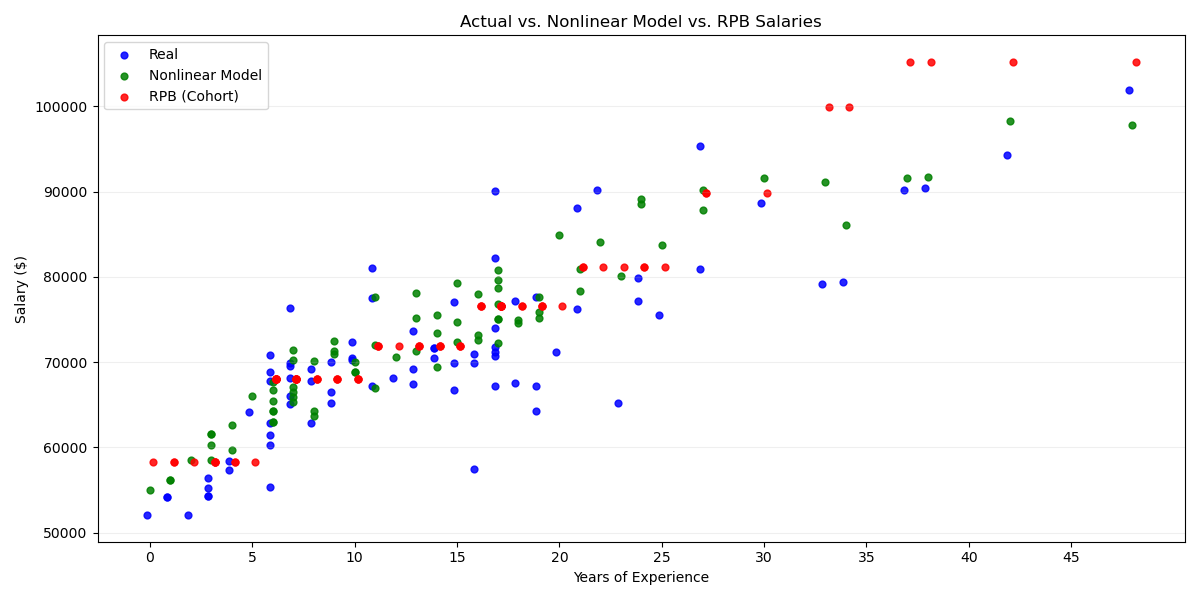

In [228]:
# --- Compare Actual vs Nonlinear Model vs RPB + total uplift-to-model cost ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
col_actual = "25-26 Salary"
col_model  = "Model NL Salary"     # nonlinear model column
col_rpb    = "RPB Salary"
col_years  = "Years of Exp"
col_name   = "Employee"            # optional

# Filter to rows with all three salary values present
plot_df = (
    staff[[col_years, col_actual, col_model, col_rpb] + ([col_name] if col_name in staff.columns else [])]
    .copy()
    .dropna(subset=[col_years, col_actual, col_model, col_rpb])
)

# Uplift cost: bring anyone below the nonlinear model up to that model (others unchanged)
deltas = np.maximum(plot_df[col_model].to_numpy() - plot_df[col_actual].to_numpy(), 0)
total_uplift_cost = float(np.nansum(deltas))
num_below_model = int(np.sum(deltas > 0))

# --- Gap vs. RPB target (in dollars) ---
df_comp = staff[[col_actual, col_model, col_rpb]].dropna()
baseline = np.maximum(df_comp[col_actual].to_numpy(), df_comp[col_model].to_numpy())
target   = df_comp[col_rpb].to_numpy()
gap = float(np.nansum(target - baseline))

# Show percentile if available
try:
    tp_display = f"{int(round(float(target_percentile)))}"
except Exception:
    tp_display = "RPB target"

print(f"People below nonlinear model: {num_below_model}")
print(f"Total cost to bring up to nonlinear model: ${total_uplift_cost:,.0f}")
print(f"Total gap vs. {tp_display}: ${gap:,.0f}")

# Plot: scatter by years; small horizontal offsets to reduce overlap
x = plot_df[col_years].to_numpy()
eps = 0.15

plt.figure(figsize=(12, 6))
plt.scatter(x - eps, plot_df[col_actual], s=24, alpha=0.85, color="blue",  label="Real")
plt.scatter(x,       plot_df[col_model],  s=24, alpha=0.85, color="green", label="Nonlinear Model")
plt.scatter(x + eps, plot_df[col_rpb],    s=24, alpha=0.85, color="red",   label="RPB (Cohort)")

plt.xlabel("Years of Experience")
plt.ylabel("Salary ($)")
plt.title("Actual vs. Nonlinear Model vs. RPB Salaries")
plt.grid(axis="y", alpha=0.2)

# x ticks every 5 years up to max observed or 40
max_years = max(40, int(np.nanmax(x)))
plt.xticks(np.arange(0, max_years + 1, 5))

# y-limits with headroom
all_y = np.concatenate([plot_df[col_actual].to_numpy(),
                        plot_df[col_model].to_numpy(),
                        plot_df[col_rpb].to_numpy()])
ymin = np.nanmin(all_y)
ymax = np.nanmax(all_y)
pad  = 0.06 * (ymax - ymin if ymax > ymin else max(ymax, 1))
plt.ylim(ymin - pad, ymax + pad)

plt.legend(loc="best")
plt.tight_layout()
plt.show()
plt.close()

=== Next-year costs with COLA=2.00% for non-raises ===
Nonlinear Model:
  People receiving raises: 57
  Total cost (raises + COLA): $328,350 (avg $4,210/person)
RPB Cohort Banded:
  People receiving raises: 54
  Total cost (raises + COLA): $363,994 (avg $4,667/person)



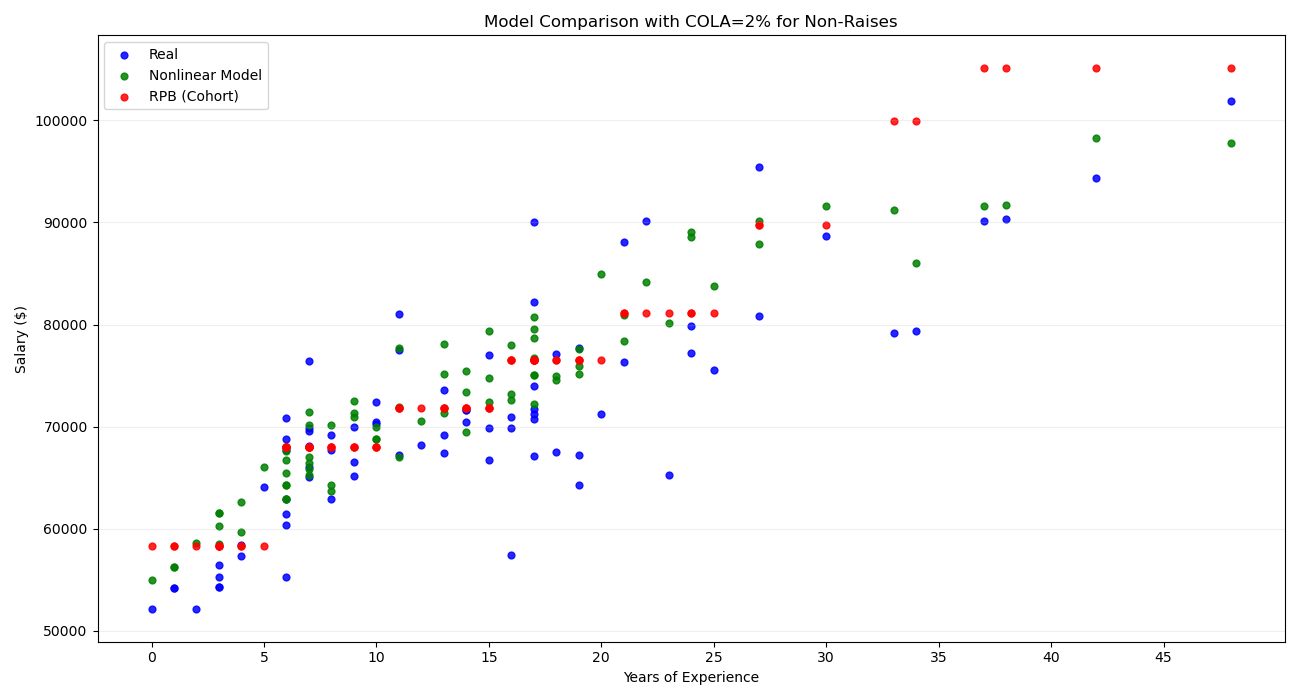

In [229]:
# --- Master comparison plot + metrics (Real vs. Nonlinear vs. Cohort RPB)
#     with COLA for non-raises ----------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Column aliases
col_real  = "25-26 Salary"
col_nlm   = "Model NL Salary"     # nonlinear model
col_rpb   = "RPB Salary"          # cohort banded salaries
col_years = "Years of Exp"
col_name  = "Employee"            # optional

# === CONFIG ===

# ===============

# Ensure required columns exist
cols_needed = [col_real, col_nlm, col_rpb, col_years]
plot_df = staff[cols_needed + ([col_name] if col_name in staff.columns else [])].dropna()

# Arrays
a   = plot_df[col_real].to_numpy(dtype=float)
nlm = plot_df[col_nlm].to_numpy(dtype=float)
rpb = plot_df[col_rpb].to_numpy(dtype=float)
x   = plot_df[col_years].to_numpy(dtype=float)

# -----------------------------
# Metrics with COLA rule
# -----------------------------
def cost_and_gap_with_cola(model_vals, label, cola=cola_rate):
    """
    Next-year pay under this plan:
      if Real < Model: raise to Model
      else:            Real * (1 + COLA)

    Cost = sum(next_year - Real)
    Gap vs RPB = sum(RPB - next_year)
    """
    next_year = np.where(a < model_vals, model_vals, a * (1.0 + cola))
    total_cost = float(np.nansum(next_year - a))
    num_raised = int(np.sum(a < model_vals))
    avg_cost = total_cost / len(plot_df)

    gap_vs_rpb = float(np.nansum(rpb - next_year))
    avg_gap = gap_vs_rpb / len(plot_df)

    return {
        "label": label,
        "num_raised": num_raised,
        "total_cost": total_cost,
        "avg_cost_per_person": avg_cost,
        "gap_vs_rpb": gap_vs_rpb,
        "avg_gap_vs_rpb": avg_gap
    }

stats = [
    cost_and_gap_with_cola(nlm, "Nonlinear Model", cola=cola_rate),
    cost_and_gap_with_cola(rpb, "RPB Cohort Banded", cola=cola_rate),  # note: gap will be ≤ 0 here
]

print(f"=== Next-year costs with COLA={cola_rate:.2%} for non-raises ===")
for s in stats:
    print(f"{s['label']}:")
    print(f"  People receiving raises: {s['num_raised']}")
    print(f"  Total cost (raises + COLA): ${s['total_cost']:,.0f} "
          f"(avg ${s['avg_cost_per_person']:,.0f}/person)")
    # print(f"  Gap vs RPB after plan: ${s['gap_vs_rpb']:,.0f} "
    #       f"(avg ${s['avg_gap_vs_rpb']:,.0f}/person)")
print("")

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(13, 7))
plt.scatter(x, a,   s=24, alpha=0.85, color="blue",  label="Real")
plt.scatter(x, nlm, s=24, alpha=0.85, color="green", label="Nonlinear Model")
plt.scatter(x, rpb, s=24, alpha=0.85, color="red",   label="RPB (Cohort)")

plt.xlabel("Years of Experience")
plt.ylabel("Salary ($)")
plt.title(f"Model Comparison with COLA={cola_rate:.0%} for Non-Raises")
plt.grid(axis="y", alpha=0.2)

# X ticks every 5 years
max_years = max(40, int(np.nanmax(x)))
plt.xticks(np.arange(0, max_years + 1, 5))

# Y-limits with headroom
all_y = np.concatenate([a, nlm, rpb])
ymin, ymax = np.nanmin(all_y), np.nanmax(all_y)
pad = 0.06 * (ymax - ymin if ymax > ymin else max(ymax, 1))
plt.ylim(ymin - pad, ymax + pad)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [230]:
# --- Calculate theoretical bump to reach nonlinear model, show top bumps ---
plt.close('all')
col_actual = "25-26 Salary"
col_model  = "Model NL Salary"
col_name   = "Employee"   # adjust if your column differs

# Calculate bump: only positive differences (no pay cuts)
staff["NL Bump"] = np.maximum(staff[col_model] - staff[col_actual], 0)

num_to_show = 5
# Sort staff by largest bump
top_bumps = (
    staff[[col_name, "Years of Exp", col_actual, col_model, "NL Bump"]]
    .dropna(subset=["NL Bump"])
    .sort_values("NL Bump", ascending=False)
    .head(num_to_show)
)

# Display top 25 bumps
print(f"Top {num_to_show} theoretical bumps to reach nonlinear model:")
display(top_bumps.style.format({
    col_actual: "${:,.0f}",
    col_model: "${:,.0f}",
    "NL Bump": "${:,.0f}"
}))

Top 5 theoretical bumps to reach nonlinear model:


,Employee,Years of Exp,25-26 Salary,Model NL Salary,NL Bump
51,"Turnbull, Jennie",16.000000,"$57,463","$72,593","$15,130"
29,"Hon, Rebecca M",23.000000,"$65,259","$80,138","$14,879"
27,"Summers, Amber",20.000000,"$71,209","$84,957","$13,748"
71,"Fonseca, Ana J",15.000000,"$66,744","$79,328","$12,584"
0,"Von Tscharner, Emma M",6.000000,"$55,328","$67,623","$12,295"


In [231]:
# --- Band-wise median table (CLOSED bands): Real, NLM, RPB  [optionally LM, SLM] ---

import numpy as np
import pandas as pd
import re

# Columns in staff
col_real   = "25-26 Salary"       # Real
col_nlm    = "Model NL Salary"    # Nonlinear model
col_rpb    = "RPB Salary"         # Cohort banded (at target_percentile)
col_lm     = "Perfect World Salary"      # optional (if present)
col_slm    = "Simple Linear Salary"      # optional (if present)
col_years  = "Years of Exp"

# ---- CLOSED band helpers: [0,5], [6,10], [11,15], …; '41+ Years' => [41, +inf]
def band_range_closed(label: str):
    s = str(label).strip()
    m_range = re.match(r"^\s*(\d+)\s*-\s*(\d+)\s*(?:yrs|years)?\s*$", s, flags=re.IGNORECASE)
    m_plus  = re.match(r"^\s*(\d+)\s*\+\s*(?:yrs|years)?\s*$", s, flags=re.IGNORECASE)
    if m_range:
        a, b = int(m_range.group(1)), int(m_range.group(2))
        return float(a), float(b)
    if m_plus:
        a = int(m_plus.group(1))
        return float(a), np.inf
    raise ValueError(f"Unrecognized band label: {label!r}")

def build_band_bins_closed(long_df: pd.DataFrame):
    bands = sorted(long_df["experience_band"].dropna().unique(),
                   key=lambda b: band_range_closed(b)[0])
    bins = []
    for b in bands:
        start, end = band_range_closed(b)
        bins.append((start, end, b))
    return bins, bands

def assign_band_from_years_closed(years: float, bins):
    if pd.isna(years):
        return np.nan
    y = float(years)
    for start, end, label in bins:
        if np.isfinite(end):
            if (y >= start) and (y <= end):
                return label
        else:  # +inf band
            if y >= start:
                return label
    return np.nan

# Build bins from your benchmark table `long`
bins, band_order = build_band_bins_closed(long)

# Decide which series to include (required 3 + optional if present)
series_map = {
    "Real": col_real,
    "EGB_NLM": col_nlm,
    "RPB": col_rpb,
}
# Optional adds if columns exist
if col_lm in staff.columns:
    series_map["EGB_LM"] = col_lm
if col_slm in staff.columns:
    series_map["SLM"] = col_slm

# Validate required columns
required_missing = [c for c in [col_years, col_real, col_nlm, col_rpb] if c not in staff.columns]
if required_missing:
    raise ValueError(f"Missing required columns in staff: {required_missing}")

# Prepare working frame
use_cols = [col_years] + [series_map[k] for k in series_map]
bw = staff[use_cols].copy()
bw["Band"] = bw[col_years].apply(lambda y: assign_band_from_years_closed(y, bins))

# Keep rows that mapped to a known band
bw = bw[bw["Band"].isin(band_order)].copy()

# Headcount per band (context)
headcount = bw.groupby("Band", as_index=True).size().reindex(band_order, fill_value=0)
headcount.name = "Headcount"

# Median by band for each included series
medians = (
    bw.groupby("Band", as_index=True)[list(series_map.values())]
      .median()
      .reindex(band_order)
)
# Rename rows to requested labels (Real, EGB_NLM, RPB, …)
medians.index.name = "Band"
medians = medians.T
medians.index = [k for k in series_map.keys()]

# Assemble final table
table = medians.copy()
table.loc["Headcount"] = headcount.to_numpy()

# Formatting
def fmt_money(v):
    try:
        return f"${v:,.0f}"
    except Exception:
        return v

salary_rows = [r for r in table.index if r != "Headcount"]
styled = (
    table.style
         .format(fmt_money, subset=pd.IndexSlice[salary_rows, :])
         .format("{:,.0f}", subset=pd.IndexSlice[["Headcount"], :])
)

display(styled)
# Optionally export:
# table.to_csv("band_wise_medians_closed.csv")

Band,0-5 yrs,6-10 yrs,11-15 yrs,16-20 yrs,21-25 yrs,26-30 yrs,31-35 yrs,36+ yrs,41+ Years
Real,"$54,302","$67,941","$70,473","$71,088","$77,182","$88,717","$79,276","$92,356",$nan
EGB_NLM,"$59,669","$66,886","$73,398","$75,530","$83,764","$90,163","$88,603","$94,728",$nan
RPB,"$58,273","$68,043","$71,867","$76,557","$81,178","$89,791","$99,892","$105,141",$nan
Headcount,11,22,13,16,7,3,2,4,0


In [232]:
# --- Achieved cohort percentiles (closed bands) for Real / EGB_NLM [/ EGB_LM / SLM / RPB] ---

import numpy as np
import pandas as pd
import re

# Columns
col_years = "Years of Exp"
col_real  = "25-26 Salary"
col_nlm   = "Model NL Salary"          # required
# Optional (included if present)
col_lm    = "Perfect World Salary"     # EGB_LM
col_slm   = "Simple Linear Salary"     # SLM
col_rpb   = "RPB Salary"               # cohort banded target at chosen percentile

# ---- Closed-band helpers: [0,5], [6,10], [11,15], …; '41+ Years' => [41, +inf)
def band_range_closed(label: str):
    s = str(label).strip()
    m_range = re.match(r"^\s*(\d+)\s*-\s*(\d+)\s*(?:yrs|years)?\s*$", s, flags=re.IGNORECASE)
    m_plus  = re.match(r"^\s*(\d+)\s*\+\s*(?:yrs|years)?\s*$", s, flags=re.IGNORECASE)
    if m_range:
        a, b = int(m_range.group(1)), int(m_range.group(2))
        return float(a), float(b)
    if m_plus:
        a = int(m_plus.group(1))
        return float(a), np.inf
    raise ValueError(f"Unrecognized band label: {label!r}")

def build_band_bins_closed(long_df: pd.DataFrame):
    bands = sorted(long_df["experience_band"].dropna().unique(),
                   key=lambda b: band_range_closed(b)[0])
    bins = []
    for b in bands:
        start, end = band_range_closed(b)
        bins.append((start, end, b))
    return bins, bands

def assign_band_from_years_closed(years: float, bins):
    if pd.isna(years):
        return np.nan
    y = float(years)
    for start, end, label in bins:
        if np.isfinite(end):
            if (y >= start) and (y <= end):
                return label
        else:  # +inf band
            if y >= start:
                return label
    return np.nan

# Inverse percentile lookup: given a band and a salary, return cohort percentile (~10..90)
def percentile_for_salary(long_df: pd.DataFrame, band_label: str, salary: float):
    sub = (
        long_df[long_df["experience_band"] == band_label]
        .dropna(subset=["percentile","salary"])
        .sort_values("salary")
    )
    if sub.empty or pd.isna(salary):
        return np.nan
    ys = sub["salary"].to_numpy(dtype=float)      # salaries
    xs = sub["percentile"].to_numpy(dtype=float)  # corresponding percentiles
    s = float(np.clip(salary, ys.min(), ys.max()))
    return float(np.interp(s, ys, xs))

# ---------------- Prep data ----------------
bins, band_order = build_band_bins_closed(long)

# choose series to evaluate
series_map = {"Real": col_real, "EGB_NLM": col_nlm}
if col_lm in staff.columns:   series_map["EGB_LM"] = col_lm
if col_slm in staff.columns:  series_map["SLM"]    = col_slm
# if col_rpb in staff.columns:  series_map["RPB"]    = col_rpb

need = [col_years] + list(series_map.values())
missing = [c for c in need if c not in staff.columns]
if missing:
    raise ValueError(f"Missing required columns in staff: {missing}")

df = staff[need].copy()
df["Band"] = df[col_years].apply(lambda y: assign_band_from_years_closed(y, bins))
df = df[df["Band"].isin(band_order)].copy()

# ---------------- Per-person achieved percentiles ----------------
for label, col in series_map.items():
    df[f"{label} %ile"] = df.apply(
        lambda r: percentile_for_salary(long, r["Band"], r[col]), axis=1
    )

# ---------------- Summaries ----------------
# 1) Per-band, percentile achieved at the band median salary for each series
band_medians = df.groupby("Band", as_index=True)[list(series_map.values())].median()

rows = []
for band in band_order:
    row = {"Band": band}
    if band in band_medians.index:
        for label, col in series_map.items():
            val = band_medians.loc[band, col]
            row[label] = percentile_for_salary(long, band, val)
    rows.append(row)
per_band_percentiles = pd.DataFrame(rows).set_index("Band")

# 2) Overall achieved percentiles (per-person %ile, aggregated)
overall = {}
for label in series_map.keys():
    s = df[f"{label} %ile"].dropna()
    overall[f"{label} (mean)"] = float(s.mean()) if len(s) else np.nan
    overall[f"{label} (median)"] = float(s.median()) if len(s) else np.nan
overall_percentiles = pd.Series(overall, name="Overall %ile")

# ---------------- Output ----------------
print("Per-band achieved cohort percentiles (percentile of the *band median* for each series):")
display(per_band_percentiles.round(1))

print("\nOverall achieved cohort percentiles (per-person %ile, aggregated):")
display(overall_percentiles.round(1).to_frame())

Per-band achieved cohort percentiles (percentile of the *band median* for each series):


,Real,EGB_NLM
Band,,
0-5 yrs,44.1,79.6
6-10 yrs,75.7,72.8
11-15 yrs,73.3,79.2
16-20 yrs,48.6,75.5
21-25 yrs,53.8,79.6
26-30 yrs,76.0,78.2
31-35 yrs,30.3,50.6
36+ yrs,43.2,49.2
41+ Years,NaN,NaN



Overall achieved cohort percentiles (per-person %ile, aggregated):


,Overall %ile
Real (mean),60.9
Real (median),67.3
EGB_NLM (mean),73.3
EGB_NLM (median),76.8


In [233]:
# --- Derive a 5-year piecewise model from the nonlinear model (degrees as outside multipliers) ---

import numpy as np
import pandas as pd

# ---------- Config for the piecewise extraction ----------
band_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]   # Total-years closed bands: [0,5], [6,10], ...
round_start_to = 100.0    # round starting salary to nearest $50
round_step_to  = 50.0     # round per-year step to nearest $20
min_years_for_ratio = 1.0 # ignore (Years<1) for alpha estimation

# ---------- Credit fraction for non-seniority years, from model params ----------
f_non_sen = float(exp_base_per_year) / float(exp_base_per_year + sen_base_per_year)  # ~ 2/3 by your params

# ---------- Estimate alpha (typical seniority share) from data if available ----------
def estimate_alpha_from_staff(staff_df: pd.DataFrame, min_years=1.0) -> float:
    try:
        yrs = pd.to_numeric(staff_df.get("Years of Exp", np.nan), errors="coerce")
        sen = pd.to_numeric(staff_df.get("Seniority",   np.nan), errors="coerce")
        mask = (yrs >= min_years) & (sen >= 0) & (sen <= yrs)
        ratios = (sen[mask] / yrs[mask]).clip(0.0, 1.0)
        if len(ratios.dropna()):
            return float(ratios.median())
    except Exception:
        pass
    # Fallback if data are thin/missing: assume 50% of experience is at-school
    return 0.50

alpha = estimate_alpha_from_staff(staff) if 'staff' in globals() else 0.50

# ---------- Map Total Years -> (YearsExp, Seniority) via alpha ----------
# We assume a typical path where Seniority = alpha * YearsExp.
# Solve for YearsExp (Y) and Seniority (S) given Total=T:
#   T = S + f*(Y - S),  S = alpha*Y  =>  T = [f + alpha*(1 - f)] * Y
#   => Y = T / [f + alpha*(1 - f)],  S = alpha * Y
def split_total_years(T: np.ndarray, f: float, alpha: float):
    denom = f + alpha * (1.0 - f)
    denom = np.maximum(denom, 1e-9)
    Y = T / denom
    S = alpha * Y
    return Y, S

# ---------- Nonlinear subtotal (BA baseline; no degree multiplier) ----------
def nl_subtotal_from_total_years(T: np.ndarray):
    Y, S = split_total_years(np.asarray(T, dtype=float), f_non_sen, alpha)
    return (
        base_salary
        + exp_cumulative(Y,  exp_base_per_year, exp_half_life_years)
        + exp_cumulative(S,  sen_base_per_year, sen_half_life_years)
        # (Optional linear adders omitted here to keep the BA baseline clean;
        #  if you want them, add them in as constants or functions of Level/etc.)
    )

# ---------- Nice rounding helpers ----------
def round_nearest(x, to=100.0):
    if to <= 0: 
        return float(x)
    return float(np.round(x / to) * to)

# ---------- Build piecewise parameters ----------
rows = []
for i in range(len(band_edges) - 1):
    a = band_edges[i]
    b = band_edges[i+1]
    # Closed bands [a,b], but we’ll compute on exact endpoints
    y_a = nl_subtotal_from_total_years(a)
    y_b = nl_subtotal_from_total_years(b)
    start_raw = float(y_a)
    step_raw  = float((y_b - y_a) / max(b - a, 1e-9))

    start_rounded = np.floor(start_raw / round_start_to) * round_start_to
    step_rounded = np.floor(step_raw / round_step_to) * round_step_to#Rounds to floor of the rounding increment

    rows.append({
        "Band": f"{int(a)}–{int(b)}",
        "TotalYears_Start": a,
        "TotalYears_End": b,
        "Width": b - a,
        "BA_Start": start_rounded,     # baseline (no degree)
        "BA_Step_per_Year": step_rounded
    })

piecewise = pd.DataFrame(rows)

# Degree multipliers (outside the piecewise)
ma_mult  = 1.0 + (deg_ma_pct  if 'deg_ma_pct'  in globals() else 0.0)
phd_mult = 1.0 + (deg_phd_pct if 'deg_phd_pct' in globals() else 0.0)

# ---------- Display ----------
print(f"Non-seniority year credit f = {f_non_sen:.3f}  "
      f"(derived from bases {exp_base_per_year:.0f}/{exp_base_per_year + sen_base_per_year:.0f})")
print(f"Typical seniority share α (estimated) = {alpha:.3f} "
      f"(median of Seniority/Years among staff; fallback 0.50)")
print(f"Degree multipliers (outside):  MA x{ma_mult:.3f},  PhD x{phd_mult:.3f}  "
      f"(stack={'yes' if ('stack_degrees' in globals() and stack_degrees) else 'no'})")

# BA baseline piecewise table
display(piecewise.style.format({
    "BA_Start": "${:,.0f}",
    "BA_Step_per_Year": "${:,.0f}"
}))

Non-seniority year credit f = 0.676  (derived from bases 1250/1850)
Typical seniority share α (estimated) = 0.333 (median of Seniority/Years among staff; fallback 0.50)
Degree multipliers (outside):  MA x1.040,  PhD x1.080  (stack=no)


,Band,TotalYears_Start,TotalYears_End,Width,BA_Start,BA_Step_per_Year
0,0–5,0,5,5,"$55,000","$1,650"
1,5–10,5,10,5,"$63,300","$1,350"
2,10–15,10,15,5,"$70,200","$1,100"
3,15–20,15,20,5,"$75,900",$900
4,20–25,20,25,5,"$80,500",$750
5,25–30,25,30,5,"$84,400",$600
6,30–35,30,35,5,"$87,600",$500
7,35–40,35,40,5,"$90,300",$450
8,40–45,40,45,5,"$92,600",$350


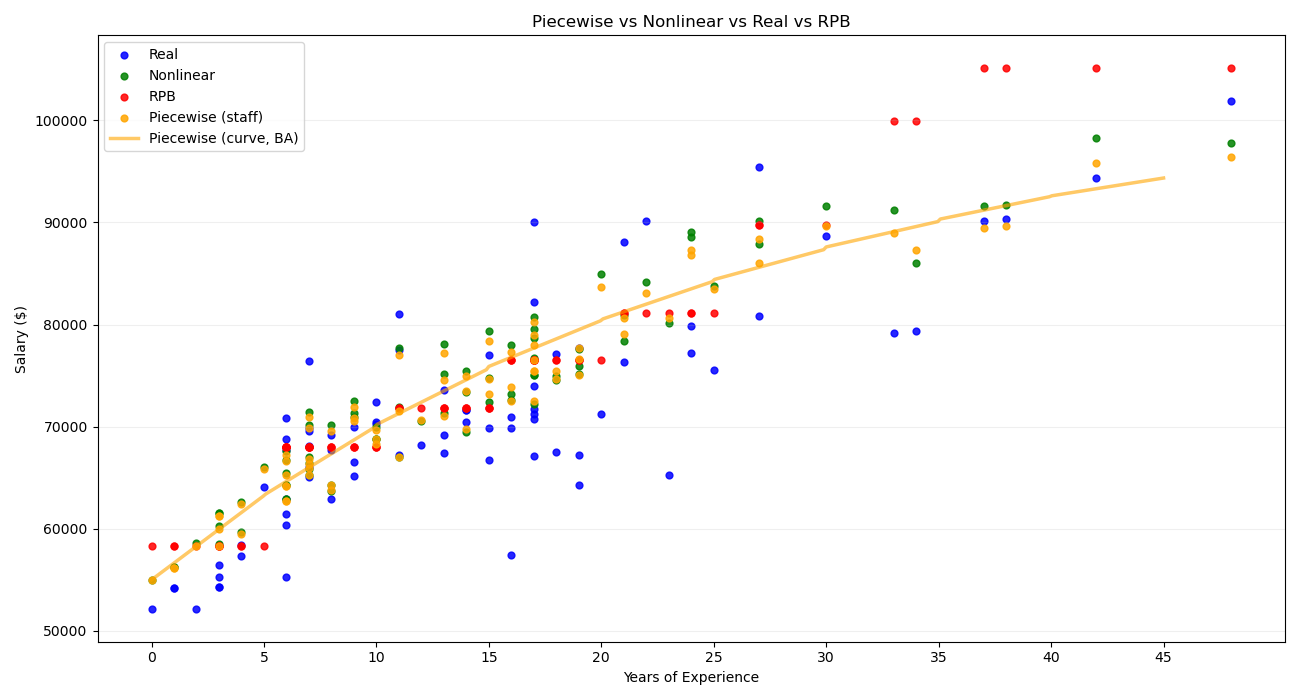

In [234]:
# --- Plot: Piecewise vs Nonlinear vs Real vs RPB ---------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- toggles (comment out or set False to hide a series) --------
SHOW_REAL       = True   # blue
SHOW_NLM        = True   # green
SHOW_RPB        = True   # red
SHOW_PW_SCATTER = True   # purple dots at staff points
SHOW_PW_CURVE   = True   # purple step/line across full x-range
# ---------------------------------------------------------------------

# --- Safety checks
required_cols = ["Years of Exp", "Seniority", "Education Level", "25-26 Salary", "Model NL Salary", "RPB Salary"]
missing = [c for c in required_cols if c not in staff.columns]
if missing:
    raise ValueError(f"Missing columns in staff: {missing}")
for col in ["TotalYears_Start","TotalYears_End","BA_Start","BA_Step_per_Year"]:
    if col not in piecewise.columns:
        raise ValueError(f"Missing column in piecewise: {col}")

# --- Helper: degree multiplier consistent with current scheme
def degree_multiplier_series(edu: pd.Series) -> np.ndarray:
    edu = edu.astype(str).str.strip()
    has_ma  = edu.str.contains(_MA_PATTERNS,  na=False)
    has_phd = edu.str.contains(_PHD_PATTERNS, na=False)
    ma_mult  = 1.0 + float(deg_ma_pct  if 'deg_ma_pct'  in globals() else 0.0)
    phd_mult = 1.0 + float(deg_phd_pct if 'deg_phd_pct' in globals() else 0.0)
    if 'stack_degrees' in globals() and stack_degrees:
        return (np.where(has_ma.to_numpy(),  ma_mult, 1.0) *
                np.where(has_phd.to_numpy(), phd_mult, 1.0))
    else:
        return np.where(has_phd.to_numpy(), phd_mult,
               np.where(has_ma.to_numpy(),  ma_mult, 1.0))

# --- Compute Total Years for each person (from current f_non_sen and alpha)
yrs = pd.to_numeric(staff["Years of Exp"], errors="coerce").fillna(0.0)
sen = pd.to_numeric(staff["Seniority"],    errors="coerce").fillna(0.0)
T   = sen + float(f_non_sen) * (yrs - sen)   # Total Years = seniority + f * (non-seniority years)

# --- Piecewise prediction at each staff member’s Total Years
# Closed band logic [start, end]; last band includes its end.
pw_pred = np.full(len(staff), np.nan, dtype=float)
for _, row in piecewise.iterrows():
    a, b = float(row["TotalYears_Start"]), float(row["TotalYears_End"])
    start, step = float(row["BA_Start"]), float(row["BA_Step_per_Year"])
    # mask: T in [a, b] (closed)
    if np.isfinite(b):
        m = (T >= a) & (T <= b)
    else:
        m = (T >= a)
    pw_base = start + (T[m] - a) * step
    pw_pred[m] = pw_base

# ... everything above unchanged ...

# Apply degree multipliers on top
deg_mult = degree_multiplier_series(staff["Education Level"])
pw_pred = pw_pred * deg_mult

# >>> NEW: persist PW salaries back to your main frame
staff = staff.copy()
staff["PW"] = pw_pred  # piecewise salary per person

# --- Build plot frame
plot_df = pd.DataFrame({
    "Years": yrs,
    "Real":  pd.to_numeric(staff["25-26 Salary"], errors="coerce"),
    "NLM":   pd.to_numeric(staff["Model NL Salary"], errors="coerce"),
    "RPB":   pd.to_numeric(staff["RPB Salary"], errors="coerce"),
    "PW":    staff["PW"]
}).dropna(subset=["Years"])

# (optional) quick check
# print(staff[["Employee","Years of Exp","Education Level","PW"]].head(8).to_string(index=False))

# --- Plot (unchanged) ---
plt.figure(figsize=(13, 7))
if SHOW_REAL: plt.scatter(plot_df["Years"], plot_df["Real"], s=24, alpha=0.85, color="blue",  label="Real")
if SHOW_NLM:  plt.scatter(plot_df["Years"], plot_df["NLM"],  s=24, alpha=0.85, color="green", label="Nonlinear")
if SHOW_RPB:  plt.scatter(plot_df["Years"], plot_df["RPB"],  s=24, alpha=0.85, color="red",   label="RPB")
if SHOW_PW_SCATTER:
    plt.scatter(plot_df["Years"], plot_df["PW"], s=24, alpha=0.85, color="orange", label="Piecewise (staff)")

# Optional: draw the piecewise *curve* across the x-axis using Total Years grid,
# then map that grid back to *Years of Exp* for display. For visibility we’ll
# just use Total Years as if it were Years (they’re close; the x-axis label
# remains Years of Experience for consistency with earlier plots).
if SHOW_PW_CURVE:
    # Create dense grid over Total Years coverage
    t_min = float(piecewise["TotalYears_Start"].min())
    t_max = float(piecewise["TotalYears_End"].max())
    t_grid = np.linspace(t_min, t_max, 400)

    pw_grid = np.full_like(t_grid, np.nan, dtype=float)
    for _, row in piecewise.iterrows():
        a, b = float(row["TotalYears_Start"]), float(row["TotalYears_End"])
        start, step = float(row["BA_Start"]), float(row["BA_Step_per_Year"])
        if np.isfinite(b):
            idx = (t_grid >= a) & (t_grid <= b)
        else:
            idx = (t_grid >= a)
        pw_grid[idx] = start + (t_grid[idx] - a) * step

    # Draw BA baseline curve (no degree multiplier), then lightly annotate degrees as multipliers
    plt.plot(t_grid, pw_grid, linewidth=2.5, color="orange", alpha=0.6, label="Piecewise (curve, BA)")

# Cosmetics
plt.xlabel("Years of Experience")
plt.ylabel("Salary ($)")
plt.title("Piecewise vs Nonlinear vs Real vs RPB")
plt.grid(axis="y", alpha=0.2)

# X ticks every 5 years up to max observed or 40
max_years = max(40, int(np.nanmax(plot_df["Years"])))
plt.xticks(np.arange(0, max_years + 1, 5))

# Y-limits with headroom
stack = []
if SHOW_REAL: stack.append(plot_df["Real"].to_numpy())
if SHOW_NLM:  stack.append(plot_df["NLM"].to_numpy())
if SHOW_RPB:  stack.append(plot_df["RPB"].to_numpy())
if SHOW_PW_SCATTER: stack.append(plot_df["PW"].to_numpy())
if SHOW_PW_CURVE:
    stack.append(pw_grid[~np.isnan(pw_grid)])
if stack:
    all_y = np.concatenate(stack)
    ymin, ymax = np.nanmin(all_y), np.nanmax(all_y)
    pad = 0.06 * (ymax - ymin if ymax > ymin else max(ymax, 1))
    plt.ylim(ymin - pad, ymax + pad)

plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [235]:
# --- Plan Table: PW vs NLM vs RPB, with Raise-to-Model-or-2% bump rule ---
import numpy as np
import pandas as pd
import re

# Columns
col_real  = "25-26 Salary"
col_pw    = "PW"                # piecewise model
col_nlm   = "Model NL Salary"   # nonlinear model
col_rpb   = "RPB Salary"        # cohort-banded salary at target_percentile
col_years = "Years of Exp"

# ---------- Use the SAME CLOSED band logic as your RPB step ----------
def band_range_closed(label: str):
    s = str(label).strip()
    m_range = re.match(r"^\s*(\d+)\s*-\s*(\d+)\s*(?:yrs|years)?\s*$", s, flags=re.IGNORECASE)
    m_plus  = re.match(r"^\s*(\d+)\s*\+\s*(?:yrs|years)?\s*$",  s, flags=re.IGNORECASE)
    if m_range:
        a, b = int(m_range.group(1)), int(m_range.group(2))
        return float(a), float(b)
    if m_plus:
        a = int(m_plus.group(1))
        return float(a), np.inf
    raise ValueError(f"Unrecognized band label: {label!r}")

def build_band_bins_closed(long_df: pd.DataFrame):
    bands = sorted(long_df["experience_band"].dropna().unique(),
                   key=lambda b: band_range_closed(b)[0])
    return [(band_range_closed(b)[0], band_range_closed(b)[1], b) for b in bands], bands

def assign_band_from_years_closed(years: float, bins):
    if pd.isna(years): return np.nan
    y = float(years)
    for start, end, label in bins:
        if np.isfinite(end):
            if (y >= start) and (y <= end):  # CLOSED interval
                return label
        else:
            if y >= start:
                return label
    return np.nan

# ---------- Inverse: salary -> percentile within the SAME band ----------
def percentile_for_salary_strict(long_df: pd.DataFrame, band_label: str, salary: float):
    sub = (
        long_df[long_df["experience_band"] == band_label]
        .dropna(subset=["percentile", "salary"])
        .sort_values("percentile")            # ensure 10 < 25 < 50 < 75 < 90
    )
    if sub.empty or pd.isna(salary):
        return np.nan
    xs = sub["percentile"].to_numpy(dtype=float)  # 10..90
    ys = sub["salary"].to_numpy(dtype=float)      # salaries at those percentiles

    # clip into known salary range for this band
    s = float(np.clip(salary, ys.min(), ys.max()))

    # if s exactly hits a cohort point, return it exactly (avoid tiny interp drift)
    hit = np.isclose(s, ys)
    if hit.any():
        return float(xs[hit.argmax()])

    # otherwise interpolate salary->percentile (invert monotone map)
    # since ys is monotone in xs, we can swap roles via np.interp
    return float(np.interp(s, ys, xs))

# ---------- Build bins once (from the same `long` you used for RPB) ----------
bins, band_order = build_band_bins_closed(long)

# ---------- Working dataframe ----------
need = [col_real, col_pw, col_nlm, col_rpb, col_years]
missing = [c for c in need if c not in staff.columns]
if missing:
    raise ValueError(f"Missing required columns in staff: {missing}")

df = staff[need].copy()
df["Band"] = df[col_years].apply(lambda y: assign_band_from_years_closed(y, bins))
df = df[df["Band"].isin([b for _,_,b in bins])].copy()

# ---------- Raise-to-model-or-2% rule ----------
def apply_raise_rule(real, model, bump=0.02, tol=0.02):
    if pd.isna(real) or pd.isna(model):
        return np.nan
    # if real is meaningfully below model (more than tol), raise to model
    if real < model * (1 - tol):
        return model
    # otherwise just give the bump
    return real * (1 + bump)

for label, col in [("PW", col_pw), ("NLM", col_nlm), ("RPB", col_rpb)]:
    df[f"{label} Plan Salary"] = [
        apply_raise_rule(r, m, bump=0.02, tol=0.02)
        for r, m in zip(df[col_real], df[col])
    ]

# ---------- Cost vs real ----------
costs = {}
for label in ["PW", "NLM", "RPB"]:
    new_sal  = df[f"{label} Plan Salary"].to_numpy(float)
    real_sal = df[col_real].to_numpy(float)
    uplift   = np.maximum(new_sal - real_sal, 0)
    costs[label] = {
        "Total Cost": float(np.nansum(uplift)),
        "Avg Cost per Person": float(np.nanmean(uplift)),
        "Num Raised": int(np.sum(uplift > 0)),
    }

# ---------- Achieved cohort percentiles (using CLOSED bands + strict inverse) ----------
overall_pct = {}
for label in ["PW", "NLM", "RPB"]:
    per_person_pct = df.apply(
        lambda r: percentile_for_salary_strict(long, r["Band"], r[f"{label} Plan Salary"]),
        axis=1
    )
    overall_pct[label] = {
        "Mean %ile":   float(per_person_pct.mean()),
        "Median %ile": float(per_person_pct.median()),
    }

plan_table = pd.DataFrame.from_dict(costs, orient="index")
pct_table  = pd.DataFrame.from_dict(overall_pct, orient="index")

print("=== Cost vs Real (raise-to-model-or-2% bump) ===")
display(plan_table.round(0))

print("=== Overall Achieved Cohort Percentiles (closed bands, strict inverse) ===")
display(pct_table.round(1))

# --- Optional sanity: for the RPB plan at P=target_percentile, per-band medians should
#     map back near that same percentile.
if "target_percentile" in globals():
    by_band = df.groupby("Band")[["RPB Plan Salary"]].median()
    by_band["%ile_of_median"] = [
        percentile_for_salary_strict(long, b, by_band.loc[b, "RPB Plan Salary"])
        for b in by_band.index
    ]
    print(f"\nSanity check for RPB plan @ P{float(target_percentile):g} (band medians -> percentiles):")
    display(by_band.round(0))

=== Cost vs Real (raise-to-model-or-2% bump) ===


,Total Cost,Avg Cost per Person,Num Raised
PW,315969.0,4051.0,78
NLM,333541.0,4276.0,78
RPB,369795.0,4741.0,78


=== Overall Achieved Cohort Percentiles (closed bands, strict inverse) ===


,Mean %ile,Median %ile
PW,75.9,78.8
NLM,76.3,79.3
RPB,79.5,77.2



Sanity check for RPB plan @ P70 (band medians -> percentiles):


,RPB Plan Salary,%ile_of_median
Band,,
0-5 yrs,58273.0,77.0
11-15 yrs,71882.0,77.0
16-20 yrs,76557.0,77.0
21-25 yrs,81178.0,77.0
26-30 yrs,90491.0,79.0
31-35 yrs,99892.0,78.0
36+ yrs,105141.0,84.0
6-10 yrs,69300.0,78.0
